## Video kürzen

In [16]:
from moviepy.video.io.VideoFileClip import VideoFileClip

start = (0, 29, 39)  # Startzeit: 29 Minuten, 39 Sekunden
end = (0, 33, 10)    # Endzeit: 33 Minuten, 10 Sekunden

clip = VideoFileClip("./parabelRitter.mp4")
subclip = clip.subclip(start, end)
subclip.write_videofile("./parabelRitter_cut.mp4")

Moviepy - Building video ./parabelRitter_cut.mp4.
MoviePy - Writing audio in parabelRitter_cutTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video ./parabelRitter_cut.mp4



Moviepy - Done !
Moviepy - video ready ./parabelRitter_cut.mp4


## Rechteck festlegen

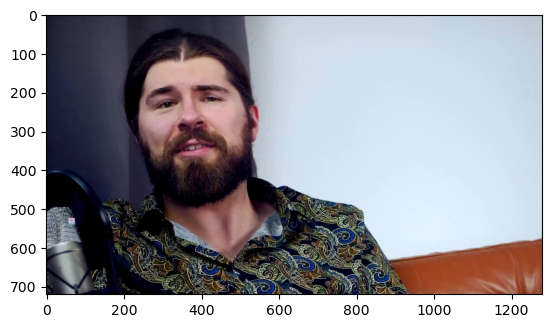

In [17]:
import numpy as np
from moviepy.video.io.VideoFileClip import VideoFileClip
import cv2
from matplotlib import pyplot as plt

# Video öffnen
video = VideoFileClip('./parabelRitter_cut.mp4')

# Frame raussuchen, wo das Quadrat zu sehen ist
start_frame = video.get_frame(4.2)

# Leeres Bild erstellen, das die gleiche Größe wie das Video hat
blank_image = np.zeros(start_frame.shape, dtype=np.uint8)

# rotes Rechteck zeichnen
x1, y1, x2, y2 = 60, 525, 70, 535
cv2.rectangle(blank_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

# Rechteck über das Frame legen
start_frame_with_rect = cv2.addWeighted(start_frame, 1, blank_image, 0.5, 0)

# Frame in RGB umwandeln
# start_frame_with_rect = cv2.cvtColor(start_frame_with_rect, cv2.COLOR_BGR2RGB)

# Frame anzeigen
plt.imshow(start_frame_with_rect)
plt.show()

## Blaues Quadrat ausschneiden

In [18]:
from moviepy.video.io.VideoFileClip import VideoFileClip
from moviepy.video.fx.all import crop, resize

# Video öffnen
video = VideoFileClip('./parabelRitter_cut.mp4')

# Video croppen
cropped_video = video.fx(crop, x1=x1, y1=y1, x2=x2, y2=y2)

# Video auf die gewünschte Größe hochskalieren
cropped_video = cropped_video.fx(resize, width=400)

# Video speichern
cropped_video.write_videofile('./parabelRitter_blauesQuadrat.mp4')

Moviepy - Building video ./parabelRitter_blauesQuadrat.mp4.
MoviePy - Writing audio in parabelRitter_blauesQuadratTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video ./parabelRitter_blauesQuadrat.mp4



Moviepy - Done !
Moviepy - video ready ./parabelRitter_blauesQuadrat.mp4


## Histogramme vergleichen

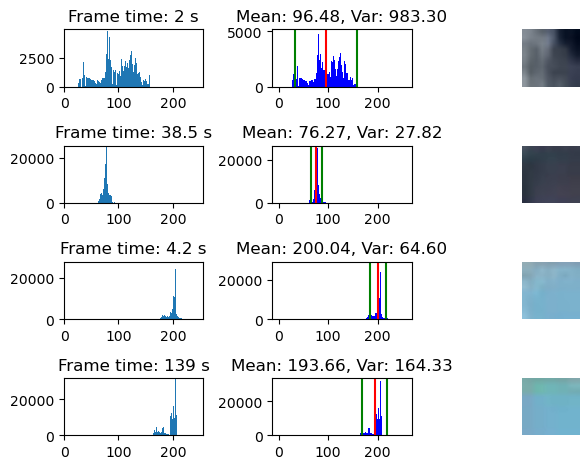

In [19]:
from moviepy.video.io.VideoFileClip import VideoFileClip
import numpy as np
import matplotlib.pyplot as plt

# Lade Video und wähle Frames aus
video = VideoFileClip('./parabelRitter_blauesQuadrat.mp4')
frame_times = [2, 38.5, 4.2, 139]

# Plotte Histogramm und Bild für jeden Frame
for i in range(len(frame_times)):
    # Frame des start_time-Zeitpunkts abrufen
    frame = video.get_frame(frame_times[i])

    # Extrahiere blauen Farbkanal
    blue_channel = frame[:, :, 2]

    # Berechne Histogramm für blauen Farbkanal
    hist, bins = np.histogram(blue_channel, bins=256, range=[0, 256])

    # Plotte Histogramm
    plt.subplot(len(frame_times), 3, i*3+1)
    plt.bar(bins[:-1], hist, width=1)
    plt.xlim(min(bins), max(bins))
    plt.ylim(0, max(hist))
    plt.title(f'Frame time: {frame_times[i]} s')

    # Plotte Mittelwert und Varianz
    mean = np.mean(blue_channel)
    var = np.var(blue_channel)
    plt.subplot(len(frame_times), 3, i*3+2)
    plt.axvline(x=mean, color='r')
    plt.axvline(x=mean-2*np.sqrt(var), color='g')
    plt.axvline(x=mean+2*np.sqrt(var), color='g')
    plt.hist(blue_channel.ravel(), bins=256, range=[0, 256], color='b')
    plt.title(f'Mean: {mean:.2f}, Var: {var:.2f}')

    # Plotte Bild
    plt.subplot(len(frame_times), 3, i*3+3)
    plt.imshow(frame)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Klassifizierung durchführen

In [20]:
import cv2
from moviepy.video.io.VideoFileClip import VideoFileClip
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
from tqdm import tqdm
import numpy as np

# Lade Video
video = VideoFileClip('./parabelRitter_blauesQuadrat.mp4')

# Definiere Schwellwerte für Mittelwert und Varianz
mean_threshold = 150
var_threshold = 200

# Klassifiziere jeden Frame des Videos
classifications = []
classified_frames = []
for i, frame in tqdm(enumerate(video.iter_frames()), total=video.fps * video.duration):
    # Extrahiere den blauen Farbkanal
    blue_channel = frame[:, :, 2]

    # Berechne Mittelwert und Varianz des Histogramms
    mean = np.mean(blue_channel)
    var = np.var(blue_channel)

    # Klassifiziere den Frame als blaues Quadrat oder nicht
    is_blue_square = mean > mean_threshold and var < var_threshold
    if is_blue_square:
        classifications.append(True)
    else:
        classifications.append(False)

    # Füge Klassifizierung als Text-Overlay zum Frame hinzu
    text = 'Blaues Quadrat' if is_blue_square else 'Pause'
    frame = np.copy(frame)
    textsize = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
    textX = int((frame.shape[1] - textsize[0]) / 2)
    textY = int((frame.shape[0] + textsize[1]) / 2)
    cv2.putText(frame, text, (textX, textY), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0) if classifications[i] else (0, 0, 255), 2)
    classified_frames.append(frame)

# Erstelle Video aus klassifizierten Frames
video_out = ImageSequenceClip(classified_frames, fps=video.fps)

# Speichere Video
video_out.write_videofile("./parabelRitter_blauesQuadrat_mitKlassifizierung.mp4", codec="mpeg4")

100%|██████████| 5277/5276.75 [00:03<00:00, 1386.50it/s]


Moviepy - Building video ./parabelRitter_blauesQuadrat_mitKlassifizierung.mp4.
Moviepy - Writing video ./parabelRitter_blauesQuadrat_mitKlassifizierung.mp4



Moviepy - Done !
Moviepy - video ready ./parabelRitter_blauesQuadrat_mitKlassifizierung.mp4


## Zeitintervalle festlegen

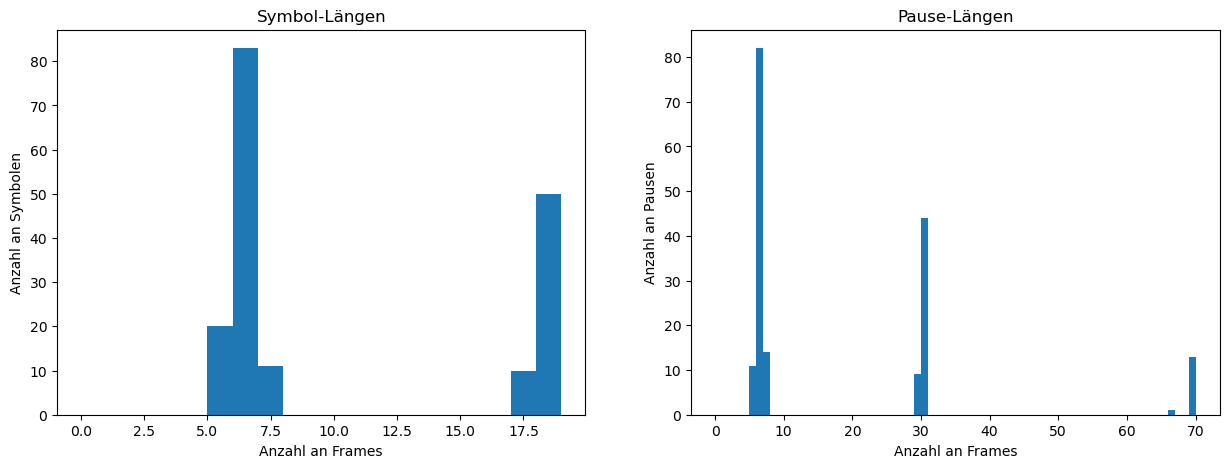

In [21]:
import matplotlib.pyplot as plt

# Initialisiere Listen für die Längen von Symbolen und Pausen
symbol_lengths = []
pause_lengths = []

# Initialisiere Variablen für die aktuelle Länge von Symbolen und Pausen
current_symbol_length = 0
current_pause_length = 0

# Gehe alle Klassifizierungen durch und sammle Längen von Symbolen und Pausen
for classification in classifications:
    if classification:
        # Wenn das aktuelle Frame als Symbol klassifiziert wurde, erhöhe die Länge des aktuellen Symbols
        current_symbol_length += 1

        # Wenn die Länge der aktuellen Pause größer als die Mindestlänge für Pausen ist,
        # füge die Länge der Pause zur Liste der Pause-Längen hinzu und setze die Länge der aktuellen Pause zurück auf 0
        if current_pause_length > 0:
            pause_lengths.append(current_pause_length)
            current_pause_length = 0
    else:
        # Wenn das aktuelle Frame nicht als Symbol klassifiziert wurde, erhöhe die Länge der aktuellen Pause
        current_pause_length += 1

        # Wenn die Länge des aktuellen Symbols größer als die Mindestlänge für Symbole ist,
        # füge die Länge des Symbols zur Liste der Symbol-Längen hinzu und setze die Länge des aktuellen Symbols zurück auf 0
        if current_symbol_length > 0:
            symbol_lengths.append(current_symbol_length)
            current_symbol_length = 0

# Erstelle Histogramme der Längen von Symbolen und Pausen
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

ax[0].hist(symbol_lengths, bins=range(0, max(symbol_lengths) + 1))
ax[0].set_title('Symbol-Längen')
ax[0].set_xlabel('Anzahl an Frames')
ax[0].set_ylabel('Anzahl an Symbolen')

ax[1].hist(pause_lengths, bins=range(0, max(pause_lengths) + 1))
ax[1].set_title('Pause-Längen')
ax[1].set_xlabel('Anzahl an Frames')
ax[1].set_ylabel('Anzahl an Pausen')

plt.show()


## Sequenz in Morse-Code umwandeln

In [22]:
# Initialisiere Variablen für den aktuellen Zustand und den Zähler für die Anzahl an Frames seit dem letzten Zustandswechsel
current_state = None
counter = 0

# Initialisiere Variablen für die Schwellwerte
symbol_threshold = 15
pause_threshold = 15
word_threshold = 60

# Initialisiere String für die Morse-Code-Übersetzung
morse_code = ""
morse_frames = []

def counter2morse(counter, state, morse_code):
    if state:
        if counter <= symbol_threshold:
            morse_code += "."
        else:
            morse_code += "-"
    elif counter >= pause_threshold:
        if counter < word_threshold:
            morse_code += " "
        else:
            morse_code += "   "
    return morse_code

# Gehe alle Klassifizierungen durch und übersetze sie in Morse-Code
for classification in classifications:
    if current_state is None:
        # Setze den aktuellen Zustand beim ersten Durchlauf
        current_state = classification
        counter = 1
    elif current_state != classification:
        # Wenn sich der Zustand ändert, schauen wir wie lange der vorherige Zustand angedauert hat und entscheiden ob es ein kurzes oder langes Symbol bzw. eine kurze oder lange Pause war
        morse_code = counter2morse(counter, current_state, morse_code)

        # Setze den Zähler zurück auf 1, da wir den aktuellen Frame schon gezählt haben
        counter = 1

        # Aktualisiere den aktuellen Zustand
        current_state = classification
    else:
        # Wenn der Zustand gleich geblieben ist, erhöhe den Zähler
        counter += 1

# Entscheide am Ende des Loops was der letzte Zustand war und füge das entsprechende Symbol bzw. die entsprechende Pause zum Morse-Code hinzu
morse_code = counter2morse(counter, current_state, morse_code)
    
print(morse_code)

   -.. . .-.   ... ..- -.-. .... . -. -.. .   ... -.-. .... .-. . .. -... -   .- ..- ..-.   ... . .. -. . --   .-- . --.   -.. .. .   -. ..- -- -- . .-.   ..--- ...--   .- -.   -.. .. .   .-- .- -. -..   -.. . .-.   -. .- -.-. .... .-. .. -.-. .... - . -. .-.-.- .-.-.-   


## Morse-Code übersetzen

In [23]:
morse_dict = {
    ".-": "A",
    "-...": "B",
    "-.-.": "C",
    "-..": "D",
    ".": "E",
    "..-.": "F",
    "--.": "G",
    "....": "H",
    "..": "I",
    ".---": "J",
    "-.-": "K",
    ".-..": "L",
    "--": "M",
    "-.": "N",
    "---": "O",
    ".--.": "P",
    "--.-": "Q",
    ".-.": "R",
    "...": "S",
    "-": "T",
    "..-": "U",
    "...-": "V",
    ".--": "W",
    "-..-": "X",
    "-.--": "Y",
    "--..": "Z",
    ".----": "1",
    "..---": "2",
    "...--": "3",
    "....-": "4",
    ".....": "5",
    "-....": "6",
    "--...": "7",
    "---..": "8",
    "----.": "9",
    "-----": "0",
    "--..--": ",",
    ".-.-.-": ".",
    "..--..": "?",
    "-..-.": "/",
    ".--.-.": "@",
    "-....-": "-",
    "-.--.": "(",
    "-.--.-": ")",
    ".-..-.": "\"",
    ".----.": "'",
    "-...-": "=",
    "-.-.--": "!",
    ".-.-.": "+",
    "-.-.-.": ";",
    "---...": ":",
    "-..-.": "_",
    "...-..-": "$",
    ".-...": "&",
    ".-.-.": "ä",
    "---.": "ö",
    "..--.": "ü",
    "...-.-": "ß"
}

def translate_morse_code(morse_code):
    # Initialisiere übersetzten String
    translated = ""
    
    # Teile den Morse-Code String in einzelne Wörter auf (3 aufeinanderfolgende Leerzeichen)
    words = morse_code.split("   ")
    
    # Gehe jedes Wort durch und übersetze es
    for word in words:
        # Teile jedes Wort in einzelne Morse-Code-Zeichen auf
        characters = word.split(" ")
        
        # Gehe jedes Morse-Code-Zeichen durch und übersetze es mit dem Wörterbuch
        for character in characters:
            translated += morse_dict.get(character, "")
        
        # Füge ein Leerzeichen zwischen Wörtern hinzu
        translated += " "
    
    # Entferne das letzte Leerzeichen aus dem übersetzten String
    translated = translated.strip()
    
    return translated

translation = translate_morse_code(morse_code)
print(translation)

DER SUCHENDE SCHREIBT AUF SEINEM WEG DIE NUMMER 23 AN DIE WAND DER NACHRICHTEN..
